In [263]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load Data

In [264]:
ratings_df = pd.read_csv('ratings_small.csv')
movies_df = pd.read_csv('movies_metadata.csv')

<ipython-input-264-af5da81a39ec>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_df = pd.read_csv('movies_metadata.csv')


# Step 2: Data Processing


In [265]:
# Filter movies that a user likes (rating > 3.5)
# liked_movies_df = ratings_df[ratings_df['rating'] > 3.5]

In [266]:
movies_df['id'] = pd.to_numeric(movies_df['id'], errors='coerce')
ratings_df['movieId'] = ratings_df['movieId'].astype('float64')

# Drop rows with NaN in 'id' after conversion
movies_df = movies_df.dropna(subset=['id'])

In [267]:
# Merge with movie metadata to get genres
movies_ratings_with_genre = ratings_df.merge(movies_df, left_on='movieId', right_on='id')


In [268]:
movies_ratings_with_genre.head(-10)

,userId,movieId,rating,timestamp,adult,belongs_to_collection,budget,genres,homepage,id,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,1,1371.0,2.5,1260759135,False,"{'id': 1575, 'name': 'Rocky Collection', 'post...",17000000,"[{'id': 18, 'name': 'Drama'}]",NaN,1371.0,...,1982-05-28,270000000.0,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The greatest challenge.,Rocky III,False,6.6,894.0
1,4,1371.0,4.0,949810302,False,"{'id': 1575, 'name': 'Rocky Collection', 'post...",17000000,"[{'id': 18, 'name': 'Drama'}]",NaN,1371.0,...,1982-05-28,270000000.0,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The greatest challenge.,Rocky III,False,6.6,894.0
2,7,1371.0,3.0,851869160,False,"{'id': 1575, 'name': 'Rocky Collection', 'post...",17000000,"[{'id': 18, 'name': 'Drama'}]",NaN,1371.0,...,1982-05-28,270000000.0,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The greatest challenge.,Rocky III,False,6.6,894.0
3,19,1371.0,4.0,855193404,False,"{'id': 1575, 'name': 'Rocky Collection', 'post...",17000000,"[{'id': 18, 'name': 'Drama'}]",NaN,1371.0,...,1982-05-28,270000000.0,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The greatest challenge.,Rocky III,False,6.6,894.0
4,21,1371.0,3.0,853852263,False,"{'id': 1575, 'name': 'Rocky Collection', 'post...",17000000,"[{'id': 18, 'name': 'Drama'}]",NaN,1371.0,...,1982-05-28,270000000.0,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The greatest challenge.,Rocky III,False,6.6,894.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44979,652,26791.0,5.0,1439588577,False,NaN,1000000,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,26791.0,...,2001-03-30,852206.0,119.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Brigham City,False,7.3,4.0
44980,652,26843.0,5.0,1440269953,False,NaN,35000000,"[{'id': 28, 'name': 'Action'}, {'id': 36, 'nam...",NaN,26843.0,...,1981-04-17,0.0,173.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,He was a man of honor in a war without any.,Lion of the Desert,False,7.5,36.0
44981,652,60086.0,4.0,1439587482,False,NaN,0,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",http://www.babysitterwantedfilm.com/,60086.0,...,2009-02-06,0.0,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,No experience necessary...,Babysitter Wanted,False,5.3,53.0
44982,652,69495.0,3.0,1442085805,False,NaN,0,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 28,...",NaN,69495.0,...,2008-04-08,0.0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Lone Rider,True,4.4,4.0


# Step 3: Feature Engineering


In [269]:
import ast

def extract_genres(genres_str):
    try:
        genres = ast.literal_eval(genres_str)
        if not isinstance(genres, list):
            print(f"Unexpected format (not a list): {genres_str}")
            return []
        return [genre['name'] for genre in genres if 'name' in genre]
    except Exception as e:
        print(f"Error parsing genres: {genres_str}, Error: {e}")
        return []

movies_ratings_with_genre['genres'] = movies_ratings_with_genre['genres'].apply(extract_genres)


In [322]:
user_genre_df = movies_ratings_with_genre.explode('genres').groupby(['userId', 'genres']).mean()['rating'].unstack(fill_value=0)
# avg_rating_df = liked_movies_with_genre.groupby(['userId', 'genres']).mean()['rating'].unstack(fill_value=0)


<ipython-input-322-7921827f6f04>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  user_genre_df = movies_ratings_with_genre.explode('genres').groupby(['userId', 'genres']).mean()['rating'].unstack(fill_value=0)


In [306]:
user_genre_df.head()

genres,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.0,2.625000,2.500000,0.0,2.000000,0.0,0.000000,0.00,1.00,0.000000,0.000000,0.000000,3.000000,0.000000,0.0,0.000000,0.000000,0.0
2,3.555556,3.428571,5.0,3.562500,3.400000,4.0,3.475000,4.0,3.000000,0.00,3.25,3.500000,3.000000,3.375000,3.642857,3.166667,0.0,3.555556,4.000000,0.0
3,3.875000,3.625000,0.0,4.166667,3.100000,0.0,3.406250,4.0,4.000000,3.00,0.00,2.750000,0.000000,3.300000,3.600000,3.833333,4.0,3.900000,3.000000,0.0
4,4.480000,4.384615,5.0,4.187500,4.555556,5.0,4.138889,3.4,4.875000,5.00,4.75,4.444444,4.333333,4.555556,4.000000,4.105263,0.0,4.500000,4.666667,0.0
5,3.944444,3.300000,4.0,3.777778,4.055556,4.0,3.964286,3.5,4.083333,4.25,4.00,3.937500,4.000000,4.125000,3.857143,4.000000,0.0,4.083333,0.000000,2.5


<ipython-input-307-cd01d6349436>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_ratings = liked_movies_with_genre.groupby(['userId', 'genres']).mean()['rating'].unstack(fill_value=0)


TypeError: ignored

In [323]:
user_genre_df['total_ratings'] = user_genre_df.sum(axis=1)

# Normalize each genre count by the total number of ratings for that user
for genre in user_genre_df.columns[:-1]:  # Exclude the total_ratings column
    user_genre_df[genre] = user_genre_df[genre] / user_genre_df['total_ratings']

# Drop the total_ratings column as it's no longer needed
user_genre_df = user_genre_df.drop(columns=['total_ratings'])

user_genre_df.head(10)
# print(user_genre_df.columns)

genres,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.235955,0.224719,0.000000,0.179775,0.000000,0.000000,0.000000,0.089888,0.000000,0.000000,0.000000,0.269663,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.058372,0.056288,0.082086,0.058486,0.055818,0.065669,0.057050,0.065669,0.049252,0.000000,0.053356,0.057460,0.049252,0.055408,0.059806,0.051988,0.000000,0.058372,0.065669,0.000000
3,0.072354,0.067686,0.000000,0.077800,0.057883,0.000000,0.063601,0.074688,0.074688,0.056016,0.000000,0.051348,0.000000,0.061617,0.067219,0.071576,0.074688,0.072821,0.056016,0.000000
4,0.055737,0.054551,0.062207,0.052098,0.056677,0.062207,0.051494,0.042301,0.060652,0.062207,0.059097,0.055295,0.053913,0.056677,0.049766,0.051075,0.000000,0.055986,0.058060,0.000000
5,0.056854,0.047565,0.057655,0.054452,0.058456,0.057655,0.057140,0.050448,0.058856,0.061258,0.057655,0.056754,0.057655,0.059457,0.055596,0.057655,0.000000,0.058856,0.000000,0.036034
6,0.073984,0.057543,0.000000,0.057029,0.077323,0.064736,0.068332,0.032368,0.070130,0.064736,0.000000,0.097104,0.000000,0.000000,0.080920,0.057543,0.032368,0.079571,0.000000,0.086314
7,0.061851,0.056228,0.000000,0.059352,0.059352,0.056228,0.063843,0.074971,0.063725,0.000000,0.074971,0.065600,0.046857,0.074971,0.069616,0.065600,0.000000,0.069348,0.037486,0.000000
8,0.061506,0.061054,0.073265,0.065124,0.061054,0.037989,0.062598,0.048843,0.073265,0.000000,0.000000,0.067838,0.065124,0.062411,0.061506,0.073265,0.000000,0.068177,0.000000,0.056984
9,0.084498,0.075561,0.000000,0.069641,0.068249,0.077998,0.074999,0.000000,0.077998,0.000000,0.000000,0.077998,0.077998,0.074099,0.077998,0.087748,0.000000,0.075213,0.000000,0.000000


In [324]:
genre_totals = user_genre_df.sum(axis=0)

# Normalize each user's genre count by the total number of ratings for that genre
for genre in user_genre_df.columns:
    user_genre_df[genre] = user_genre_df[genre] / genre_totals[genre]

user_genre_df.head(10)

genres,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.005135,0.005201,0.000000,0.003867,0.000000,0.000000,0.000000,0.003078,0.000000,0.000000,0.000000,0.006049,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.001303,0.001340,0.003998,0.001273,0.001292,0.002694,0.001227,0.002045,0.001358,0.000000,0.001827,0.001589,0.001823,0.001320,0.001342,0.001230,0.000000,0.001278,0.003159,0.000000
3,0.001615,0.001611,0.000000,0.001693,0.001340,0.000000,0.001368,0.002326,0.002060,0.004266,0.000000,0.001420,0.000000,0.001467,0.001508,0.001694,0.008948,0.001594,0.002695,0.000000
4,0.001244,0.001299,0.003030,0.001134,0.001312,0.002552,0.001108,0.001318,0.001673,0.004737,0.002023,0.001529,0.001995,0.001350,0.001116,0.001209,0.000000,0.001226,0.002793,0.000000
5,0.001269,0.001132,0.002808,0.001185,0.001353,0.002365,0.001229,0.001571,0.001623,0.004665,0.001974,0.001569,0.002134,0.001416,0.001247,0.001364,0.000000,0.001289,0.000000,0.001381
6,0.001651,0.001370,0.000000,0.001241,0.001790,0.002655,0.001470,0.001008,0.001934,0.004930,0.000000,0.002685,0.000000,0.000000,0.001815,0.001362,0.003878,0.001742,0.000000,0.003307
7,0.001381,0.001338,0.000000,0.001292,0.001374,0.002306,0.001373,0.002335,0.001757,0.000000,0.002567,0.001814,0.001734,0.001785,0.001562,0.001552,0.000000,0.001518,0.001803,0.000000
8,0.001373,0.001453,0.003568,0.001417,0.001413,0.001558,0.001347,0.001521,0.002020,0.000000,0.000000,0.001876,0.002410,0.001486,0.001380,0.001734,0.000000,0.001493,0.000000,0.002183
9,0.001886,0.001799,0.000000,0.001516,0.001580,0.003199,0.001613,0.000000,0.002151,0.000000,0.000000,0.002157,0.002887,0.001765,0.001750,0.002076,0.000000,0.001647,0.000000,0.000000


# Step 4: Clustering


In [325]:
kmeans = KMeans(n_clusters=5)  # Adjust number of clusters as needed
user_genre_df['kmeans_cluster'] = kmeans.fit_predict(user_genre_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Step 5: Optimal Cluster Number


In [326]:
silhouette_scores = []
for n_clusters in range(2, 11):
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(user_genre_df)
    silhouette_avg = silhouette_score(user_genre_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [327]:
print(silhouette_scores)

[0.7240485534011322, 0.7668046383474811, 0.8409317340434191, 0.9950338614777436, 0.8517991714430623, 0.6431100193144946, 0.51805067571074, 0.5284557760440467, 0.34817399507084024]


In [328]:
# Select the number of clusters with the highest silhouette score
optimal_clusters = np.argmax(silhouette_scores) + 2  # +2 because range starts at 2

In [329]:
optimal_clusters

5

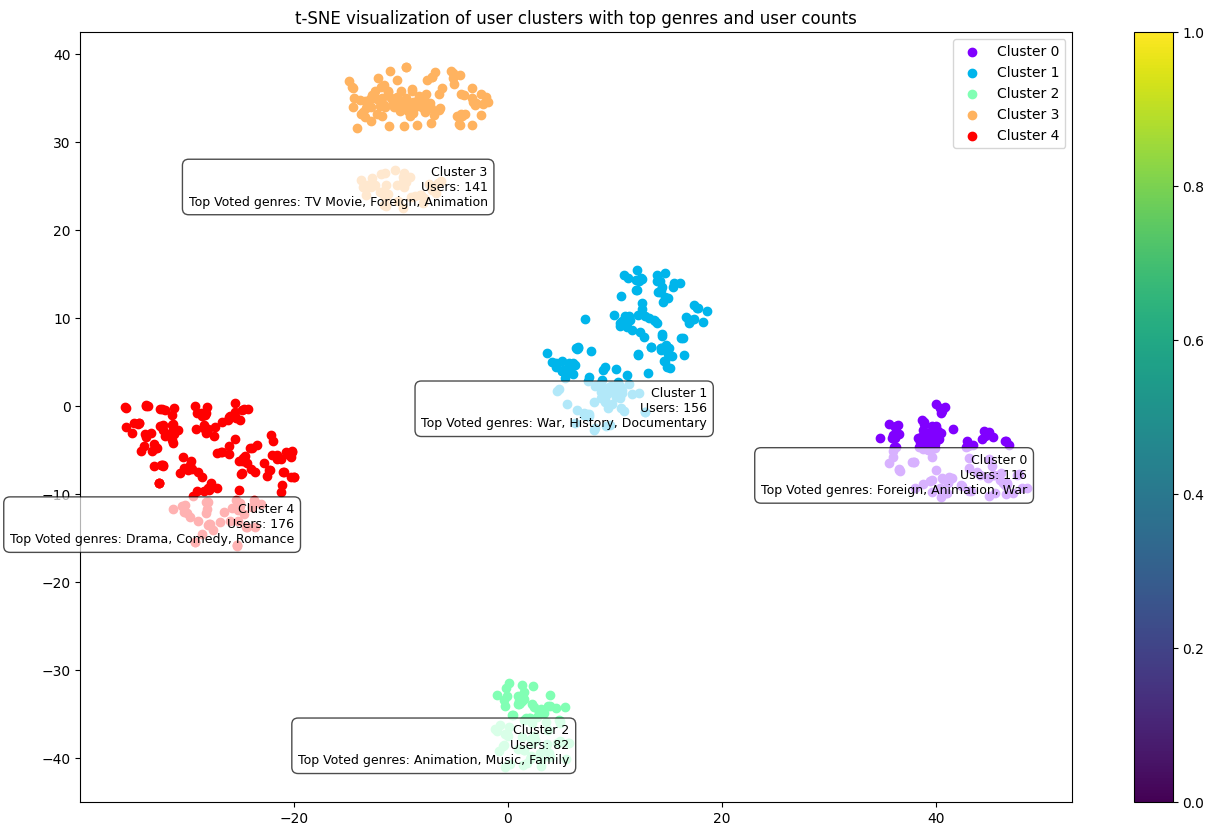

In [330]:
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(user_genre_df)

# Number of users in each cluster
user_counts = user_genre_df['kmeans_cluster'].value_counts()

# Calculate the mean rating for each genre in each cluster
genre_means = user_genre_df.groupby('kmeans_cluster').mean()

# Prepare the figure
plt.figure(figsize=(16,10))
colors = plt.cm.rainbow(np.linspace(0, 1, num_clusters))

# Plot each cluster with its centroid
for i in range(num_clusters):
    # Filter data points belonging to the current cluster
    cluster_tsne = tsne_results[user_genre_df['kmeans_cluster'] == i]
    plt.scatter(cluster_tsne[:, 0], cluster_tsne[:, 1], c=[colors[i]], label=f'Cluster {i}')

    # Find the centroid for annotation
    centroid = cluster_tsne.mean(axis=0)
    # Get the top 3 genres
    top_genres = genre_means.columns[np.argsort(-genre_means.iloc[i, :])[:3]]
    top_genres_str = ", ".join(top_genres)
   # Annotation text
    annotation = f"Cluster {i}\nUsers: {user_counts[i]}\nTop Voted genres: {top_genres_str}"

    # Determine position for annotation
    x_position = np.max(cluster_tsne[:, 0])
    y_position = np.min(cluster_tsne[:, 1])

    # Add annotation to the plot
    plt.text(x_position, y_position, annotation, fontsize=9, verticalalignment='bottom',
             horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5'))

plt.colorbar()
plt.title('t-SNE visualization of user clusters with top genres and user counts')
plt.legend()
plt.show()

In [286]:
# # # Step 6: t-SNE Visualization
# tsne = TSNE(n_components=2, random_state=0)
# tsne_results = tsne.fit_transform(user_genre_df)

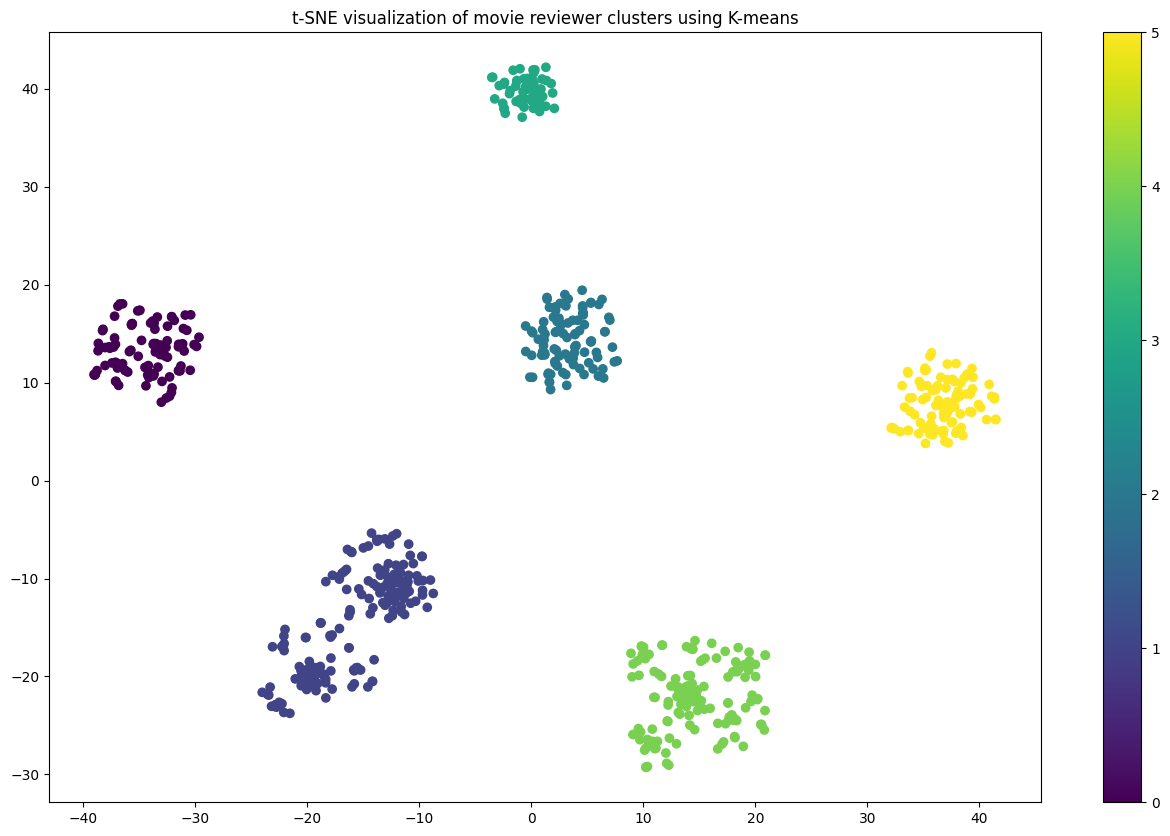

In [287]:
# plt.figure(figsize=(16,10))
# plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=user_genre_df['kmeans_cluster'])
# plt.colorbar()
# plt.title('t-SNE visualization of movie reviewer clusters using K-means')
# plt.show()

Number of users in each cluster:
4    176
1    156
3    141
0    116
2     82
Name: kmeans_cluster, dtype: int64


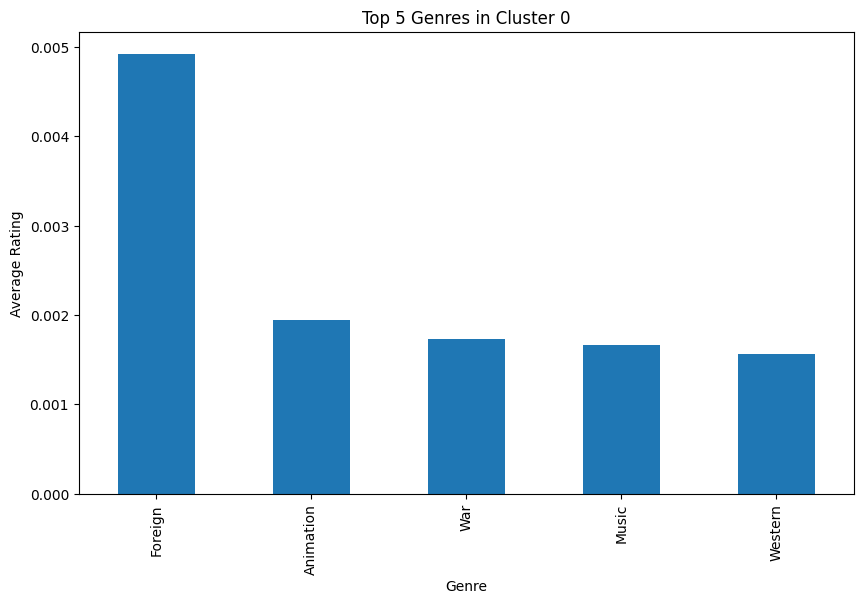

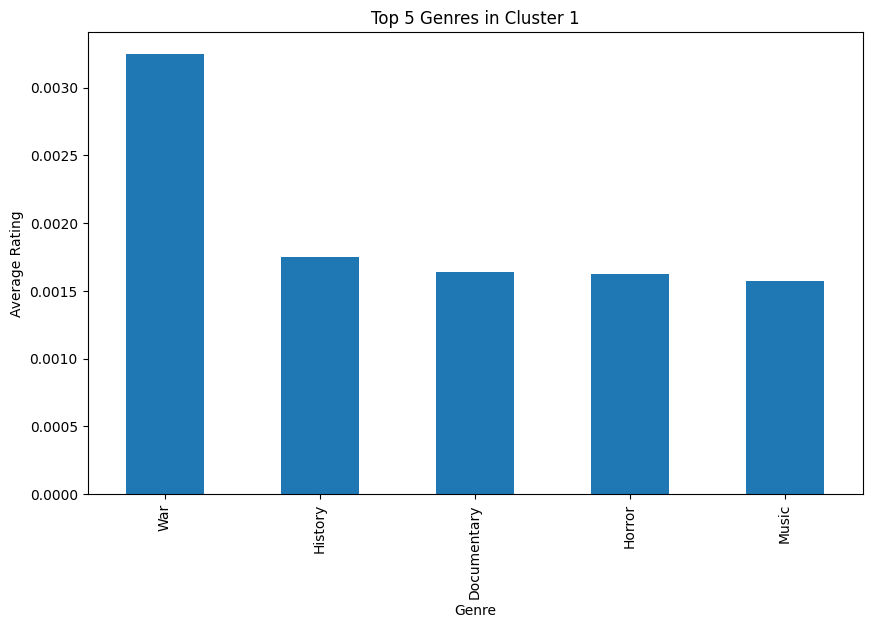

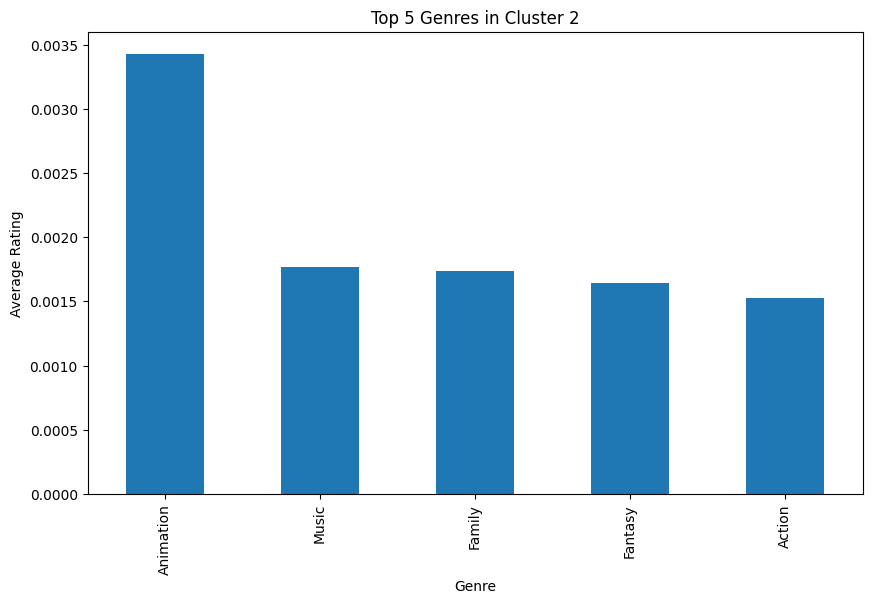

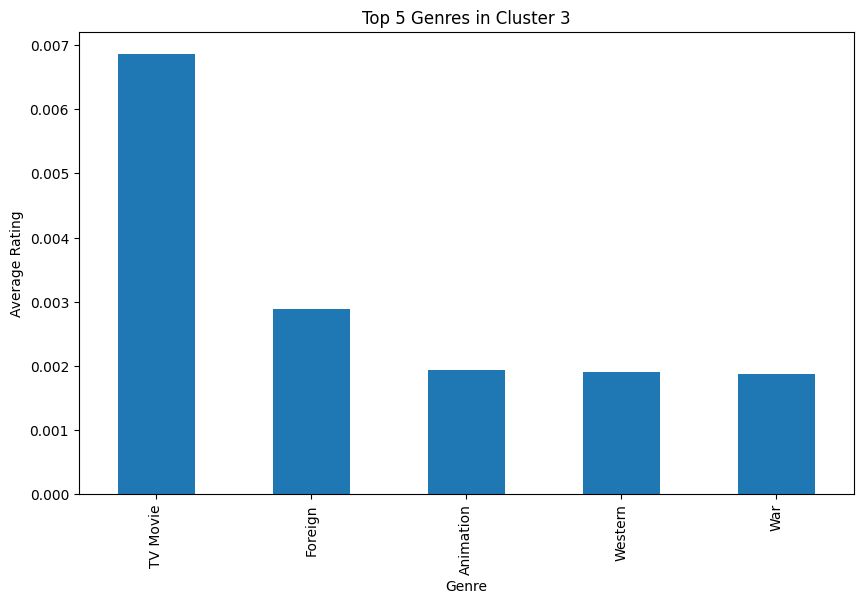

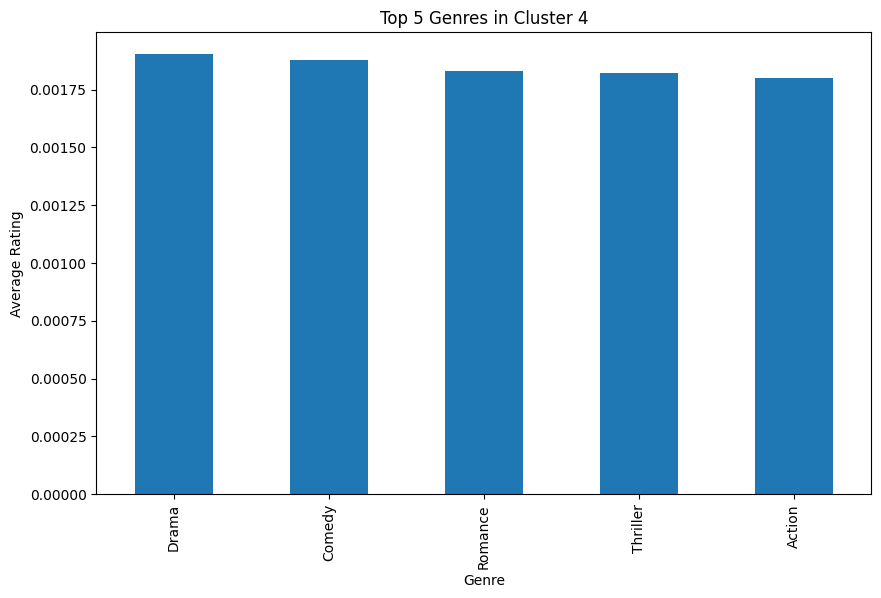

In [331]:
user_counts = user_genre_df['kmeans_cluster'].value_counts()
print("Number of users in each cluster:")
print(user_counts)

# Step 7: Identify Genres per Cluster
# Calculate the mean rating for each genre in each cluster
genre_means = user_genre_df.groupby('kmeans_cluster').mean()

# Step 8: Visualization of Genres per Cluster
num_clusters = kmeans.n_clusters
num_top_genres = 5  # Number of top genres to display for each cluster

for i in range(num_clusters):
    plt.figure(figsize=(10, 6))
    cluster_genres = genre_means.loc[i].sort_values(ascending=False)[:num_top_genres]
    cluster_genres.plot(kind='bar')
    plt.title(f'Top {num_top_genres} Genres in Cluster {i}')
    plt.ylabel('Average Rating')
    plt.xlabel('Genre')
    plt.show()

In [332]:
user_genre_df = user_genre_df.drop(columns=['kmeans_cluster'])


gmm = GaussianMixture(n_components=5)  # Adjust number of components as needed
user_genre_df['gmm_cluster'] = gmm.fit_predict(user_genre_df)

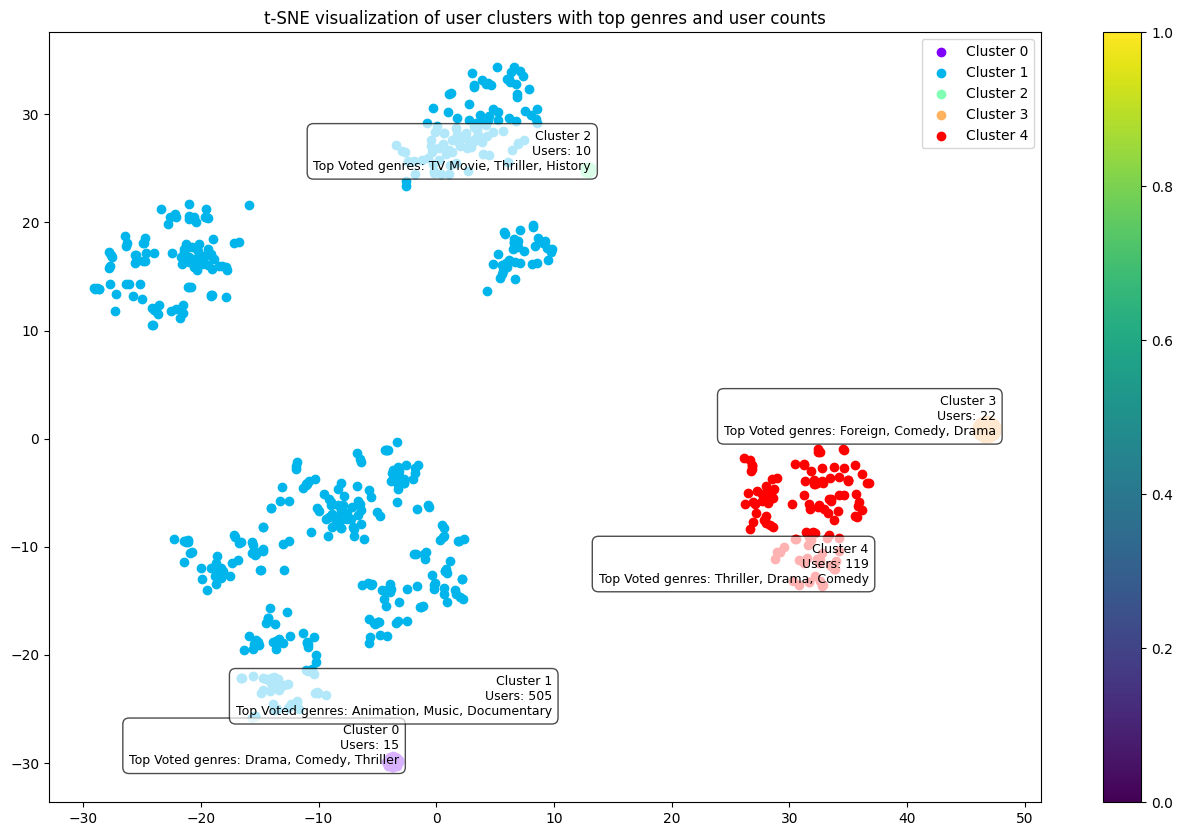

In [333]:
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(user_genre_df)

# Number of users in each cluster
user_counts = user_genre_df['gmm_cluster'].value_counts()

# Calculate the mean rating for each genre in each cluster
genre_means = user_genre_df.groupby('gmm_cluster').mean()

# Prepare the figure
plt.figure(figsize=(16,10))
colors = plt.cm.rainbow(np.linspace(0, 1, num_clusters))

# Plot each cluster with its centroid
for i in range(num_clusters):
    # Filter data points belonging to the current cluster
    cluster_tsne = tsne_results[user_genre_df['gmm_cluster'] == i]
    plt.scatter(cluster_tsne[:, 0], cluster_tsne[:, 1], c=[colors[i]], label=f'Cluster {i}')

    # Find the centroid for annotation
    centroid = cluster_tsne.mean(axis=0)
    # Get the top 3 genres
    top_genres = genre_means.columns[np.argsort(-genre_means.iloc[i, :])[:3]]
    top_genres_str = ", ".join(top_genres)
   # Annotation text
    annotation = f"Cluster {i}\nUsers: {user_counts[i]}\nTop Voted genres: {top_genres_str}"

    # Determine position for annotation
    x_position = np.max(cluster_tsne[:, 0])
    y_position = np.min(cluster_tsne[:, 1])

    # Add annotation to the plot
    plt.text(x_position, y_position, annotation, fontsize=9, verticalalignment='bottom',
             horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5'))

plt.colorbar()
plt.title('t-SNE visualization of user clusters with top genres and user counts')
plt.legend()
plt.show()

In [220]:
# tsne = TSNE(n_components=2, random_state=0)
# tsne_results = tsne.fit_transform(user_genre_df)

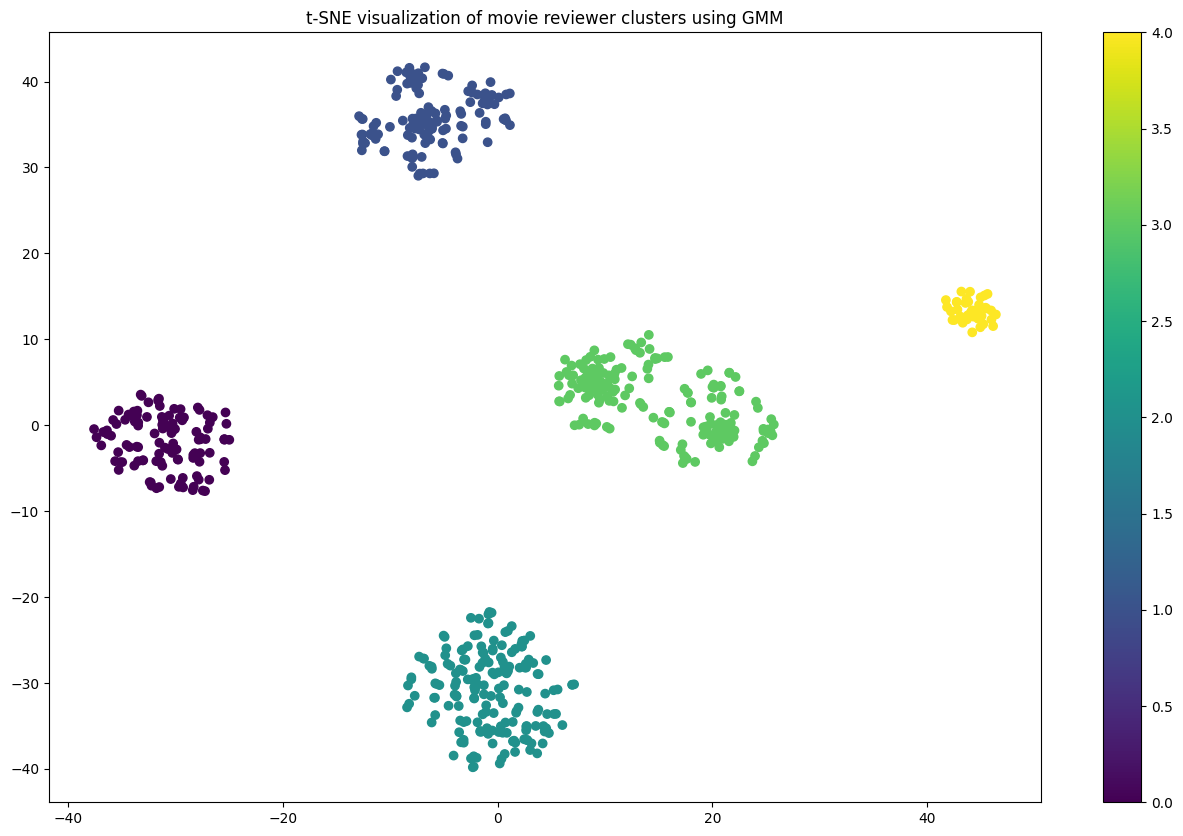

In [221]:
# plt.figure(figsize=(16,10))
# plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=user_genre_df['gmm_cluster'])
# plt.colorbar()
# plt.title('t-SNE visualization of movie reviewer clusters using GMM')
# plt.show()

Number of users in each cluster:
1    505
4    119
3     22
0     15
2     10
Name: gmm_cluster, dtype: int64


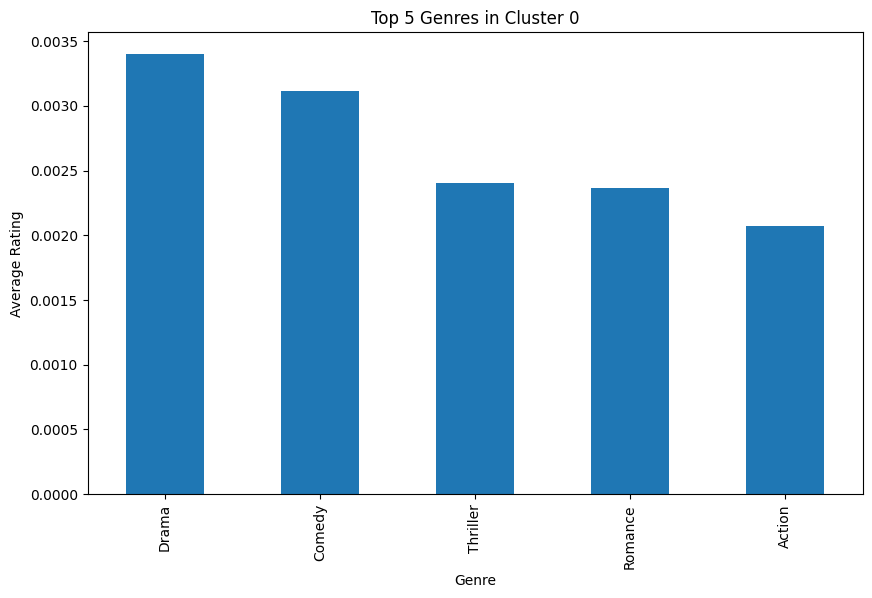

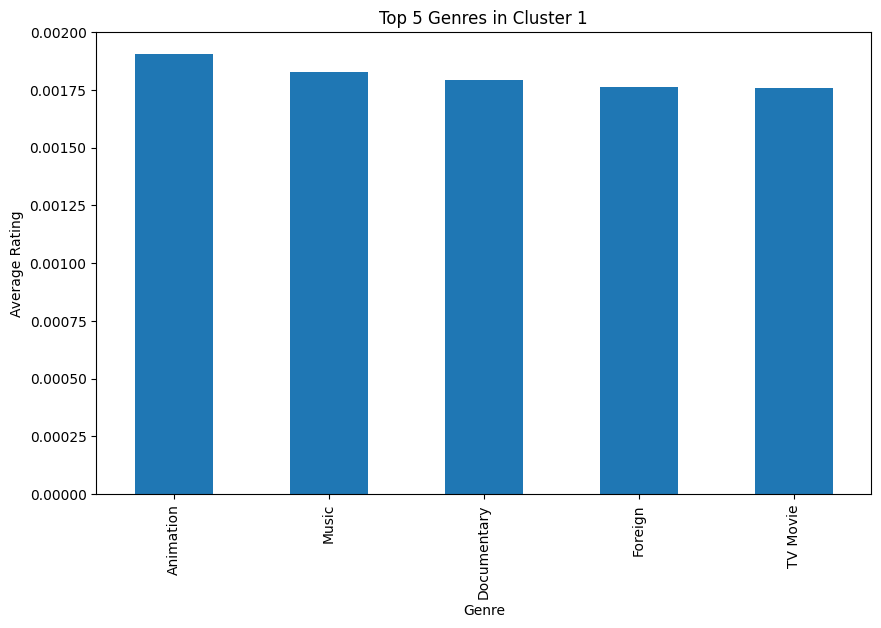

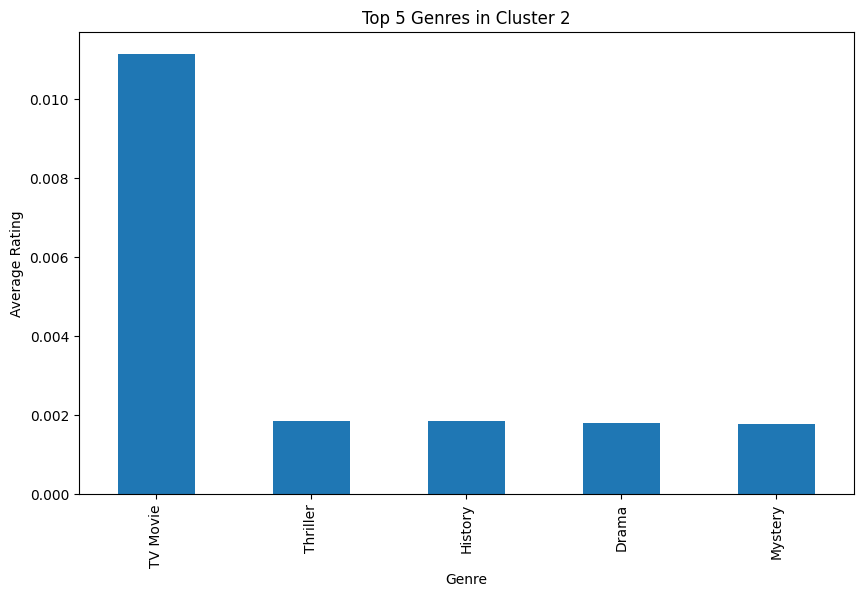

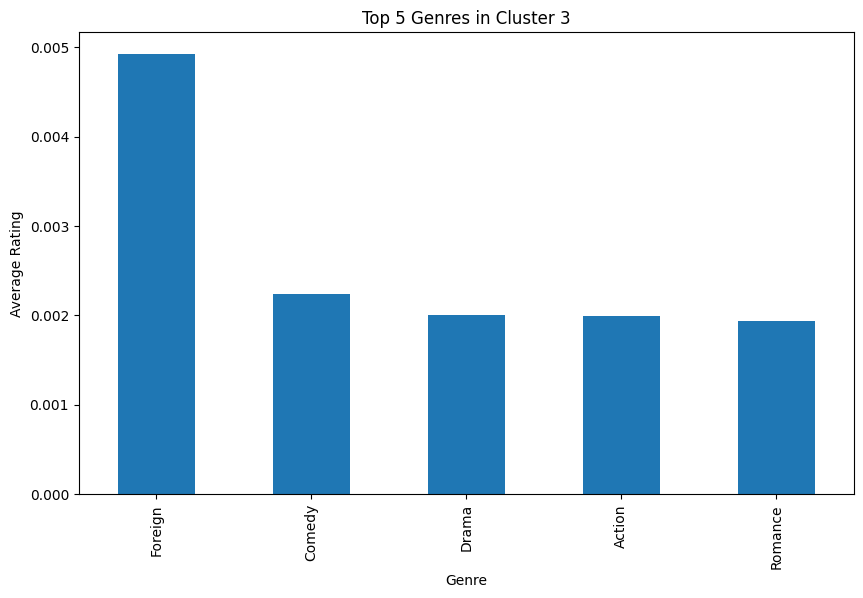

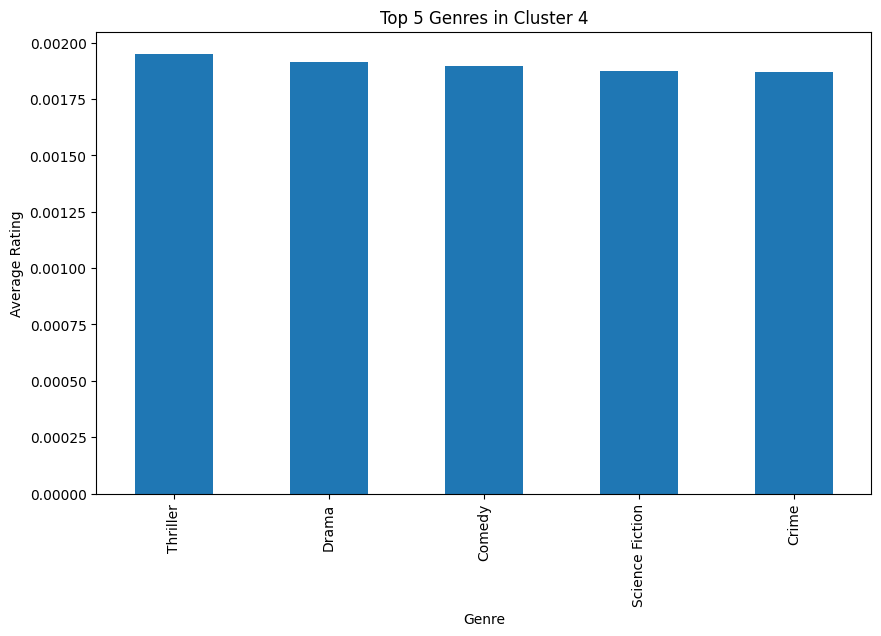

In [334]:
user_counts = user_genre_df['gmm_cluster'].value_counts()
print("Number of users in each cluster:")
print(user_counts)

# Step 7: Identify Genres per Cluster
# Calculate the mean rating for each genre in each cluster
genre_means = user_genre_df.groupby('gmm_cluster').mean()

# Step 8: Visualization of Genres per Cluster
num_clusters = gmm.n_components
num_top_genres = 5  # Number of top genres to display for each cluster

for i in range(num_clusters):
    plt.figure(figsize=(10, 6))
    cluster_genres = genre_means.loc[i].sort_values(ascending=False)[:num_top_genres]
    cluster_genres.plot(kind='bar')
    plt.title(f'Top {num_top_genres} Genres in Cluster {i}')
    plt.ylabel('Average Rating')
    plt.xlabel('Genre')
    plt.show()

In [335]:
def find_best_cluster_for_genre(genre, genre_means):
    """
    Find the cluster that has the highest average rating for the given genre.

    :param genre: The genre to search for.
    :param genre_means: DataFrame with average ratings for each genre in each cluster.
    :return: Cluster number that favors the given genre the most.
    """
    if genre not in genre_means.columns:
        raise ValueError(f"Genre '{genre}' not found in the dataset.")

    # Find the cluster with the highest average rating for the genre
    best_cluster = genre_means[genre].idxmax()
    return best_cluster



In [336]:
genre = "Romance"  # Replace with any genre you're interested in
best_cluster_for_genre = find_best_cluster_for_genre(genre, genre_means)
print(f"The cluster most likely to favor '{genre}' is Cluster {best_cluster_for_genre}.")

The cluster most likely to favor 'Romance' is Cluster 0.


In [337]:
def find_worst_cluster_for_genre(genre, genre_means):
    """
    Find the cluster that has the highest average rating for the given genre.

    :param genre: The genre to search for.
    :param genre_means: DataFrame with average ratings for each genre in each cluster.
    :return: Cluster number that favors the given genre the most.
    """
    if genre not in genre_means.columns:
        raise ValueError(f"Genre '{genre}' not found in the dataset.")

    # Find the cluster with the highest average rating for the genre
    worst_cluster = genre_means[genre].idxmin()
    return worst_cluster

In [338]:
genre = "Romance"  # Replace with any genre you're interested in
worst_cluster_for_genre = find_worst_cluster_for_genre(genre, genre_means)
print(f"The cluster likely likely to favor '{genre}' is Cluster {worst_cluster_for_genre}.")

The cluster likely likely to favor 'Romance' is Cluster 1.


In [339]:
! pip install joblib


In [340]:
from joblib import dump

# Save the KMeans model
dump(kmeans, 'kmeans_model.joblib')

# Save the GMM model
dump(gmm, 'gmm_model.joblib')

['gmm_model.joblib']

In [341]:
from joblib import load

# Load the KMeans model
kmeans = load('kmeans_model.joblib')

# Load the GMM model
gmm = load('gmm_model.joblib')